In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,6)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("/content/drive/My Drive/lending_club_data/accepted_2007_to_2018Q4.csv",low_memory=False)


### Cleaning

In [3]:
model_features = [
    # Borrower info
    'annual_inc', 'verification_status', 'emp_length', 'home_ownership', 'addr_state',
    'dti', 'purpose', 'application_type',

    # Credit risk indicators
    'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
    'mths_since_last_record', 'open_acc', 'total_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'collections_12_mths_ex_med', 'mths_since_last_major_derog',
    'delinq_2yrs', 'acc_now_delinq', 'num_tl_90g_dpd_24m',

    # Loan application terms
    'loan_amnt', 'int_rate', 'term', 'installment', 'grade', 'sub_grade',
    'funded_amnt',

    # status
    'loan_status'
]


In [4]:
model_df = df[model_features].copy()

In [5]:
keep_statuses = [
    'Fully Paid', 'Charged Off', 'Default',
    'Does not meet the credit policy. Status: Fully Paid',
    'Does not meet the credit policy. Status: Charged Off'
]

model_df = model_df[model_df['loan_status'].isin(keep_statuses)]

default_statuses = ['Charged Off', 'Default', 'Does not meet the credit policy. Status: Charged Off']

model_df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x in default_statuses else 0)

In [6]:
model_df['home_ownership'] = model_df['home_ownership'].replace({'ANY': 'OTHER', 'NONE': 'OTHER', 'OTHER': 'OTHER'})

In [7]:
model_df['emp_length'] = model_df['emp_length'].fillna('unknown')

In [8]:
model_df['dti'] = model_df['dti'].fillna(model_df['dti'].median())

In [9]:
model_df['mths_since_last_delinq'] = model_df['mths_since_last_delinq'].fillna(999)
model_df['mths_since_last_record'] = model_df['mths_since_last_record'].fillna(999)
model_df['mths_since_last_major_derog'] = model_df['mths_since_last_major_derog'].fillna(999)
model_df['num_tl_90g_dpd_24m'] = model_df['num_tl_90g_dpd_24m'].fillna(-1)

for linear models we'll add dummy number and for non linear models it'll work even Nans.

In [10]:
model_df['revol_util'] = model_df['revol_util'].fillna(model_df['revol_util'].median())

In [11]:
model_df['collections_12_mths_ex_med'] = model_df['collections_12_mths_ex_med'].fillna(0)

In [12]:
model_df['inq_last_6mths'] = model_df['inq_last_6mths'].fillna(0)

In [13]:
model_df = model_df[model_df['dti']>0]

### Feature engineering

In [14]:
model_df.dtypes

,0
annual_inc,float64
verification_status,object
emp_length,object
home_ownership,object
addr_state,object
dti,float64
purpose,object
application_type,object
fico_range_low,float64
fico_range_high,float64


One-hot encoding for features having less categories

In [15]:
one_hot_cols = ['verification_status','home_ownership','purpose']
model_df = pd.get_dummies(model_df,columns=one_hot_cols,drop_first=True)

Ordinal encoding

In [16]:
emp_map = {
    '< 1 year': 0,
    '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8,
    '9 years': 9, '10+ years': 10, 'unknown' : 99
}
model_df['emp_length'] = model_df['emp_length'].map(emp_map)

In [17]:
model_df['application_type'] = model_df['application_type'].map({'Individual' : 0,'Joint App':1})
model_df['term'] = model_df['term'].map({' 36 months' : 0, ' 60 months' : 1})

In [18]:
subgrade_order = []
for g_idx, g in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G'], 1):
    for s in range(1, 6):
        subgrade_order.append(f"{g}{s}")

subgrade_float_map = {sg: float(f"{g_idx}.{s}") for sg, (g_idx, s) in zip(subgrade_order, [(i//5 + 1, i%5 + 1) for i in range(35)])}

model_df['sub_grade'] = model_df['sub_grade'].map(subgrade_float_map)



In [19]:
model_df = model_df.drop(columns=['grade'])

Frequency encoding

In [20]:
addr_freq = df['addr_state'].value_counts(normalize=True)
model_df['addr_state_freq'] = model_df['addr_state'].map(addr_freq)
model_df = model_df.drop(columns=['addr_state'])

In [21]:
(model_df['revol_util']>100).value_counts()

,count
revol_util,
False,1339802
True,4687


Values over 100% are often invalid, noisy, or result from data entry errors so, we gonna clip them.

In [22]:
model_df['revol_util'] = model_df['revol_util'].clip(upper=100)

log transform skewed features.

In [23]:
model_df['annual_inc_log'] = np.log1p(model_df['annual_inc'])
model_df = model_df.drop(columns=['annual_inc'])

In [24]:
model_df['dti_log'] = np.log1p(model_df['dti'])
model_df = model_df.drop(columns=['dti'])

**collections_12_mths_ex_med** Skewed and peaky, but many zero. bining will be better option.

In [25]:
model_df['collections_12_mths_ex_med'].value_counts()

,count
collections_12_mths_ex_med,
0.0,1323458
1.0,19493
2.0,1292
3.0,153
4.0,53
5.0,18
6.0,9
7.0,4
10.0,2


In [26]:
model_df['collections_bins'] = pd.cut(model_df['collections_12_mths_ex_med'],
                                      bins=[-1,0,1,np.inf],
                                      labels=[0,1,2]).astype(int)
model_df.drop(columns=['collections_12_mths_ex_med'], inplace=True)

### Modeling

In [27]:
X = model_df.drop(columns=['loan_status'])
y = model_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [28]:
features_to_scale = [
    'fico_range_low','fico_range_high',
    'inq_last_6mths',
    'open_acc',
    'total_acc',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'mths_since_last_delinq',
    'mths_since_last_record',
    'mths_since_last_major_derog',
    'delinq_2yrs',
    'acc_now_delinq',
    'num_tl_90g_dpd_24m',
    'annual_inc_log',
    'dti_log',
    'loan_amnt', 'installment', 'int_rate', 'funded_amnt', 'addr_state_freq'
]

scalar = StandardScaler()
X_train[features_to_scale] = scalar.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scalar.transform(X_test[features_to_scale])


In [29]:
lr = LogisticRegression(max_iter=2000,n_jobs=-1,class_weight='balanced')
lr.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [30]:
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

In [31]:
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ROC AUC Score: 0.711121426212526
Confusion Matrix:
 [[142750  72462]
 [ 19278  34408]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.66      0.76    215212
           1       0.32      0.64      0.43     53686

    accuracy                           0.66    268898
   macro avg       0.60      0.65      0.59    268898
weighted avg       0.77      0.66      0.69    268898



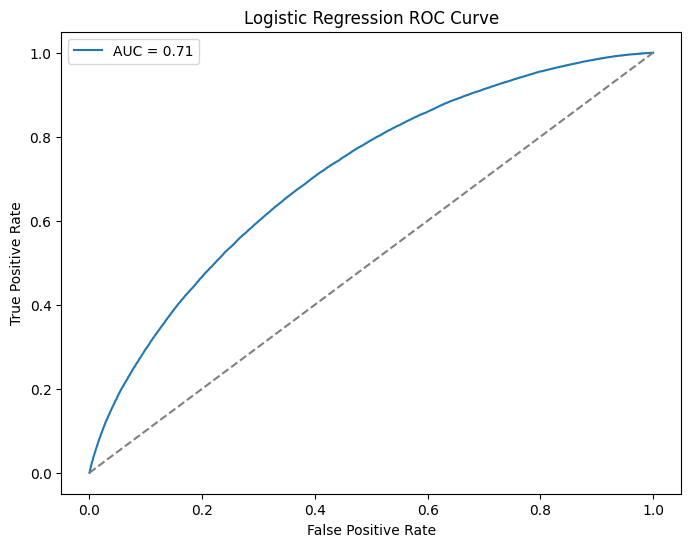

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

*  Recall for defaults (1): 0.64 — the model captures 64% of all true defaults.

*  Precision for defaults (1): 0.32 — about one-third of predicted defaults are actual defaults, reflecting the trade-off introduced by balancing: increased recall for more false positives.

*  AUC is moderate: Model distinguishes default vs. non-default better than chance, but is far from ideal for decision-making.


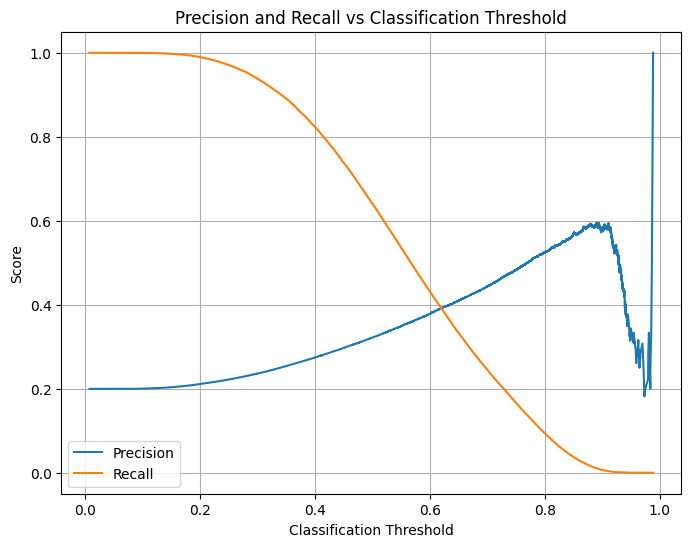

In [33]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_[0],
    "Odds Ratio": np.exp(lr.coef_[0])
})

coef_df.sort_values(by='Odds Ratio',ascending=False)

,Feature,Coefficient,Odds Ratio
18,term,0.641803,1.899903
37,purpose_small_business,0.511072,1.667078
26,home_ownership_RENT,0.327668,1.387728
20,sub_grade,0.297321,1.346247
33,purpose_medical,0.256774,1.292753
25,home_ownership_OWN,0.189207,1.208291
38,purpose_vacation,0.181918,1.199516
34,purpose_moving,0.161969,1.175824
43,collections_bins,0.155030,1.167693
22,verification_status_Source Verified,0.149400,1.161137


*  Loan Term is critical: 60-month loans have much higher odds of default.

*  Purpose and Occupancy Matter: Business, medical, moving, vacation (and renters) signal elevated risk; weddings and credit card loans are safer bets.

*  Credit Score & Income: Higher FICO and income remain crucial defenses against default.

*  Other Credit Indicators: More accounts and time since major derogatory events signal stability.

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')


dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [36]:
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

In [37]:
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

ROC AUC Score: 0.5444822947896552
Confusion Matrix:
 [[175843  39369]
 [ 39089  14597]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82    215212
           1       0.27      0.27      0.27     53686

    accuracy                           0.71    268898
   macro avg       0.54      0.54      0.54    268898
weighted avg       0.71      0.71      0.71    268898



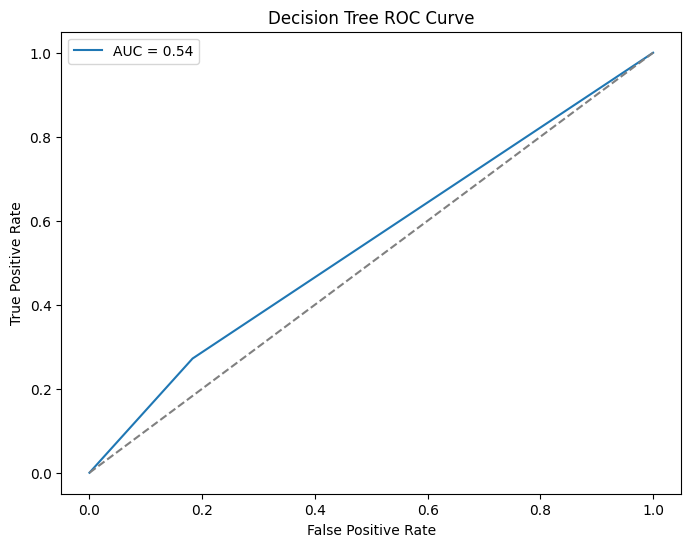

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba_dt):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.show()

*  Baseline decision tree is underperforming compared to logistic regression.
*  A score of 0.54 is only slightly better than random guessing.

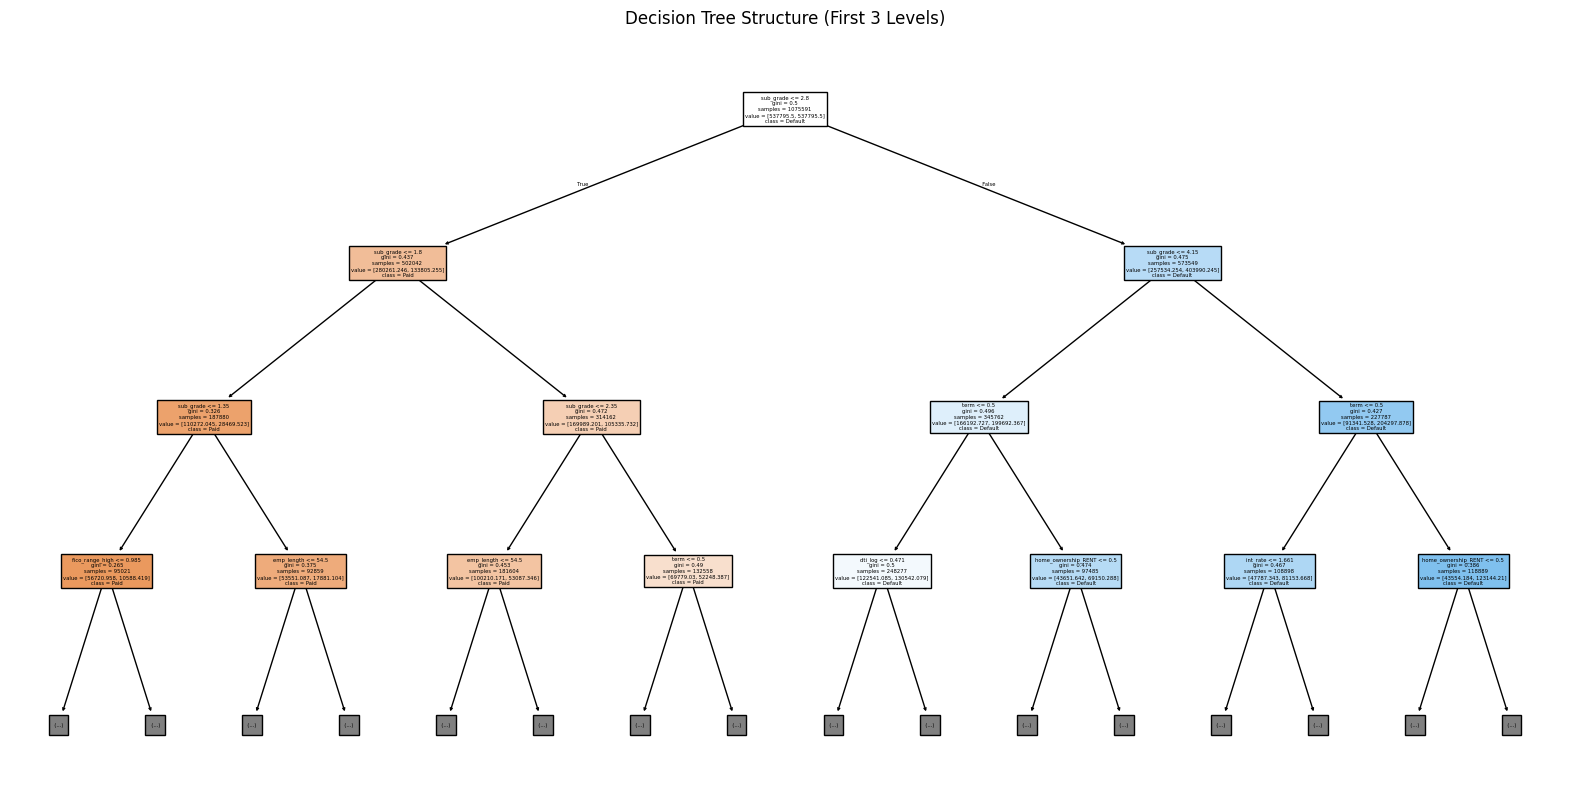

In [40]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt,
          feature_names=X.columns,
          class_names=['Paid', 'Default'],
          filled=True,
          max_depth=3)
plt.title("Decision Tree Structure (First 3 Levels)")
plt.show()
